# Experiments with no sampling

In [1]:
!pip install grandiso

  Created wheel for grandiso: filename=grandiso-2.1.1-py3-none-any.whl size=15159 sha256=c251d7de54b7fe41b17eda7f8872360f03ee7ad858d4d74198f87b2e499b3031
  Stored in directory: /root/.cache/pip/wheels/c4/a2/f8/9ed72d95be070220db1e6e0f7771e1044dd00daeca9b06bcc5
Successfully built grandiso


In [2]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

1.11.0+cu113
     |████████████████████████████████| 7.9 MB 8.4 MB/s 
     |████████████████████████████████| 3.5 MB 7.4 MB/s 


In [3]:
# install ogb

!pip install ogb

     |████████████████████████████████| 78 kB 4.5 MB/s 
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7048 sha256=8bdb7cfffbeb4aee29bf2548cfb55dbbf8ef2a2478df9dc07848e4c1bc274cac
  Stored in directory: /root/.cache/pip/wheels/d6/64/cd/32819b511a488e4993f2fab909a95330289c3f4e0f6ef4676d
Successfully built littleutils


### imports

In [297]:
import torch
from torch_geometric.data import Data
from torch_geometric.datasets import TUDataset, ZINC
import torch_geometric.utils as uts
from torch_geometric.utils import remove_self_loops, to_undirected

import numpy as np
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm

In [299]:
# Graph libraries

import networkx as nx 
from grandiso import find_motifs

In [300]:
from ogb.graphproppred import PygGraphPropPredDataset

#### Load the drive for data files:

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')
# Mount the current directory
#%cd /content/drive/My\ Drive//CS159_project

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/CS159_project


## Graph processing code

### Enriched embedding classses

### Test graph class

In [301]:
####### testgraph class ##########
class testGraph: 
  '''
  A class object for a test graph with descriptive features
  '''
  def __init__(self, graph, graph_name = None, limit = None, format = 'networkx'):
    '''
     Parameters:
     graph: a graph in the format "format" (default is networkX)
     graph_name (String): the name of a graph 
     max_n (Int): a bound for the number of subgraphs taken
    '''
    self.name = graph_name
    self.__graph = graph
    self.bound = limit
    self.format = format
  def nx_graph(self):
    '''
     returns the graph in networkX format
    '''
    return self.__graph
  def pyg_graph(self):
    if self.format != 'networkx':
      raise Exception('Not implemented yet')
    return uts.convert.from_networkx(self.__graph)
  def draw(self):
    '''
     returns a drawing of the graph
    '''
    if self.format != 'networkx':
      return None
    return nx.draw(self.nx_graph())

###  Embedding classes

#### A general embedding class

In [312]:

####### generic Embedding class ##########
class Embedding():
  '''
  A class for for handeling the embeddings from subgraph isomorphism. 
  A specific class using aparticular graph homomorphism computation algorithm or library 
  inherits this class
  '''
  def __init__(self, graph, 
               testgraphs = None , 
               symmetry = True, 
               induced = False, 
               undirected = 'True',
               format = 'Torch'):
    self.__graph = graph
    self.graph = self.__graph
    if testgraphs == None: 
        self.testgraphs = {}
    else:
        self.testgraphs = testgraphs
    self.symmetry = symmetry
    self.induced = induced
    self.undirected = undirected
    self.format = format
  def nx_graph(self):
    '''
    returns the encoded graph in networkX format
    '''
    if self.format == 'networkx':
        return self.__graph
    if self.format == 'Torch':
        return uts.to_networkx(self.__graph, to_undirected = self.undirected)
    else:
      raise Exception('Not implemented yet')
  def pyg_graph(self):
    '''
    returns the encoded graph in torch_geometric.data format
    '''
    if self.format == 'Torch':
      return self.__graph
    else:
      raise Exception("Not implemented yet")
  def draw_graph(self):
    '''
     returns a drawing of the encoded graph
    '''
    return nx.draw(self.nx_graph())
  def add(self, test_graph):
    '''
     Adds a graph to the set of test graphs
     parameters:
     test_graph (testGraph) : graph to be added
    '''
    self.testgraphs[test_graph.name] = test_graph
  def add_from_iter(self, testgraphs):
    '''
     Adds graphs from an iterrable (e.g. list) to the set of test graphs
     parameters:
     testgraphs (testGraph) : iterator of graphs to be added
    '''
    dict_new_testgraphs = {F.name : F for F in testgraphs}
    self.testgraphs.update(dict_new_testgraphs)  
  def __subIso(self, testgraph):
    pass 
  def subIsodict(self):
    pass      
  def num_encoder(self, format = 'Torch'):
    '''
    Returns the subgraph isomorphism vector in R^|testgraphs| given by (|subgraphIso(F,G)|)_F
    '''
    pass
  def __pullback(self, testgraph, embedding,  format = 'Torch'):
    # returns the testgraph with features pulled back from the target graph along a map embedding
    '''
    input:
    testgraph (testGraph): a testgraph 
    embedding (gt.vertexpropertymap) :  an embedding of testgraph into the graph
    returns:
    subgraph (torch-geometric.data): testgraph as pyg data with features pulled along embedding
    '''
    pass        
  


#### Embedding using grandIso  

In [313]:
class grandEmbedding(Embedding):
  '''
  A class for for handeling the embeddings from subgraph isomorphism. 
  '''
  def __init__(self, *kwargs):
    super().__init__(*kwargs)
  def __subIso(self, testgraph):
    '''
    params:
    testgraph (testgraph): a testgraph to map from
    returns:
    returns a list of monomorphisms of the form
    "testgraph_id": "graph_id"
    '''
    graph = super(grandEmbedding, self).nx_graph()
    return iter(find_motifs(testgraph.nx_graph(), graph, limit = testgraph.bound))
  def subIso(self, testgraph):
    # a public version of subIso, might be revoked in the future
    return self.__subIso(testgraph) 
  def num_encoder(self, format = 'Torch'):
    '''
    Returns the subgraph isomorphism vector in R^|testgraphs| given by (|subgraphIso(F,G)|)_F
    '''
    graph = super(grandEmbedding, self).nx_graph()
    num_auto = lambda x: find_motifs(x.nx_graph(), x.nx_graph(), limit = x.bound, count_only=True)
    num_all_subisos = lambda x: find_motifs(x.nx_graph(), graph, limit = x.bound, count_only=True)

    return np.array([num_all_subisos(test) for test in self.testgraphs.values()])
  def ghc_agg(self, test):
    dict_indices = map(lambda x: x.values(), self.__subIso(test))
    indices = map(lambda x: list(x), dict_indices)
    tensorlist = [torch.prod(self.graph.x[idx], dim = 0) for idx in indices]

    if len(tensorlist) == 0:
        num_node_features = self.graph.num_node_features
        return torch.zeros(num_node_features)  

    test_agg = torch.stack(tensorlist)
    
    return torch.sum(test_agg, dim = 0)
  def ghc_encoder(self, format = 'Torch'):
    '''
    An encoder in the style of the GHC paper
    '''
    embedding_tensor = torch.stack([self.ghc_agg(test) for test in self.testgraphs.values()])

    embedding_vector = embedding_tensor.flatten()
    if format == 'Torch':
        return embedding_vector
    elif format == 'numpy':
        return embedding_vector.detach().numpy()
    else:
      raise Exception("Format not supported")     


## Test graphs

In [304]:
MAX_n = 100
# cycles:
test_cycles = [testGraph(nx.cycle_graph(n), graph_name= f'c_{n}', limit = MAX_n) for n in range(3,6)]
# trees:
make_tree = lambda tree, n, m : testGraph(tree, graph_name= f'tree of size {n} number {m}', limit = MAX_n)
make_non_is_trees = lambda n : [make_tree(tree, n, m) for m, tree in enumerate(list(nx.nonisomorphic_trees(n)))]
test_trees = list(itertools.chain.from_iterable([make_non_is_trees(n) for n in range(2,6)]))
# cliques
test_cliques = [testGraph(nx.complete_graph(n), graph_name= f'_{n}', limit = MAX_n) for n in range(4,6)]

F_testlist = list(itertools.chain(test_trees,test_cycles)) 


In [266]:
g = test_cliques[0].nx_graph()
sub = test_trees[1].nx_graph()


tensor([[1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.]])

## Start SVM experiment

set up environment 

In [305]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from yellowbrick.model_selection import CVScores
from sklearn.model_selection import StratifiedKFold

## First experiment: MUTAG:

Load the data

In [306]:
dataset = TUDataset(root='data/TUDataset', name='MUTAG')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')


Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])


Process the data

### MUTAG with custom GHC encoder

In [316]:
# MUTAG with custom graphIso encoder

# lables
y = np.array([x for x in itertools.chain.from_iterable((data.y.detach().numpy() for data in dataset))])

# vectors:
add_testgraphs = lambda x: x.add_from_iter(F_testlist)

Encoded_Dataset = [grandEmbedding(data) for data in dataset]
f = list(map(add_testgraphs, Encoded_Dataset))
#Encoded_Dataset[0]
X = np.array([data.num_encoder() for data in tqdm(Encoded_Dataset)])

#%timeit Encoded_Dataset[0].ghc_encoder()




100%|██████████| 188/188 [00:04<00:00, 38.42it/s]


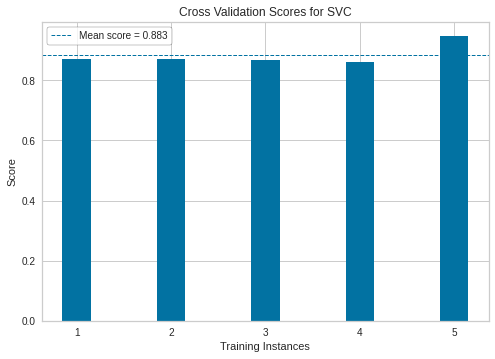

In [317]:
# Run classifier - MUTAG

clf = SVC(kernel='rbf')


cv = StratifiedKFold(n_splits=5, shuffle=True)
visualizer = CVScores(clf, cv=cv, scoring='f1_weighted', random_state=42)
visualizer.fit(X, y)        
visualizer.show()   


## Experiment: IMDB 

In [212]:
dataset = TUDataset(root='data/IMDB-BINARY', name='IMDB-BINARY')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

Extracting data/IMDB-BINARY/IMDB-BINARY/IMDB-BINARY.zip
Processing...



Dataset: IMDB-BINARY(1000):
Number of graphs: 1000
Number of features: 0
Number of classes: 2

Data(edge_index=[2, 146], y=[1], num_nodes=20)


Done!


Inspect:

In [216]:
# IMDB-Bin with custom graphIso encoder

# lables
y = np.array([x for x in itertools.chain.from_iterable((data.y.detach().numpy() for data in dataset))])

# vectors:
add_testgraphs = lambda x: x.add_from_iter(F_testlist)

Encoded_Dataset = [grandEmbedding(data) for data in dataset]
f = list(map(add_testgraphs, Encoded_Dataset))
#Encoded_Dataset[0]
#X = np.array([data.num_encoder() for data in tqdm(Encoded_Dataset)])

%timeit Encoded_Dataset[0].num_encoder()

1 loop, best of 5: 261 ms per loop


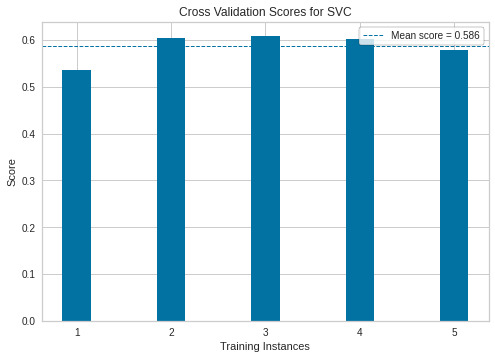

In [ ]:
# Run classifier - IMDB-BIN

clf = SVC(kernel='rbf')


cv = StratifiedKFold(n_splits=5, shuffle=True)
visualizer = CVScores(clf, cv=cv, scoring='f1_weighted', random_state=42)
visualizer.fit(X, y)        
visualizer.show()   

## Experiment: "ogbg-molhiv" 

In [ ]:
dataset = PygGraphPropPredDataset(name = "ogbg-molhiv", root = 'dataset/')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')


Dataset: PygGraphPropPredDataset(41127):
Number of graphs: 41127
Number of features: 9
Number of classes: 2

Data(edge_index=[2, 40], edge_attr=[40, 3], x=[19, 9], y=[1, 1], num_nodes=19)


In [ ]:
y_fix = y[:,0]

IndexError: ignored

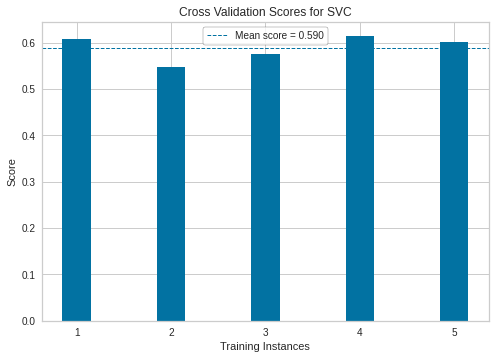

In [ ]:
# Run classifier - ogbg-molhiv

clf = SVC(kernel='rbf')


cv = StratifiedKFold(n_splits=5, shuffle=True)
visualizer = CVScores(clf, cv=cv, scoring='roc_auc', random_state=42)
visualizer.fit(X, y_fix)        
visualizer.show()   

## Zinc

In [ ]:
dataset = ZINC(root='data/ZINC',subset=True)

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

Extracting data/ZINC/molecules.zip
Processing...
Processing test dataset: 100%|██████████| 1000/1000 [00:00<00:00, 13566.99it/s]


Dataset: ZINC(10000):
Number of graphs: 10000
Number of features: 1
Number of classes: 9994

Data(x=[29, 1], edge_index=[2, 64], edge_attr=[64], y=[1])



Done!


Inspect:

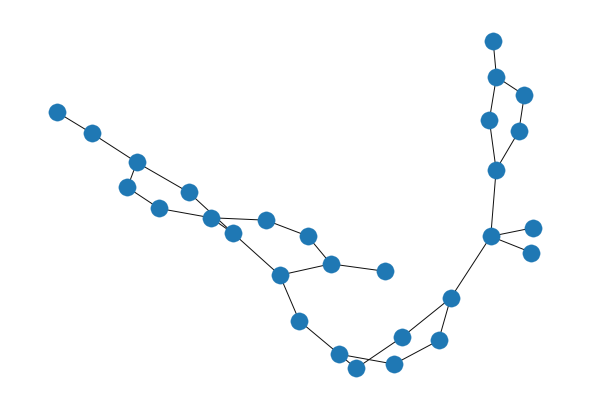

In [ ]:
to_kx = lambda x: uts.to_networkx(x,to_undirected = True)

G = to_kx(dataset[0])
nx.draw(G)


In [ ]:
# ZINC with custom GHC encoder

# lables
y = np.array([x for x in itertools.chain.from_iterable((data.y.detach().numpy() for data in dataset))])

# vectors:
add_testgraphs = lambda x: x.add_from_iter(F_testlist)

Encoded_Dataset = [GHC_Encoder(graph = data) for data in dataset]
f = list(map(add_testgraphs, Encoded_Dataset))
#Encoded_Dataset[0]
#X = np.array([data.default_encoder() for data in tqdm(Encoded_Dataset)])
#%timeit Encoded_Dataset[0].fast_encoder()
#Encoded_Dataset[0].subIndx(F_testlist[0])
#%timeit Encoded_Dataset[0].default_encoder()
%timeit Encoded_Dataset[0].ghc_encoder()
#list(Encoded_Dataset[0].subvmask(F_testlist[0]))

10 loops, best of 5: 21.8 ms per loop


## ogbg-code2